# Causality Study- Estimating the effect of stroke on age increase- Does it have a causal relationship? 

By Gabriela Gutiérrez-Colomer mentored by Dr. Felipe Alonso Atienza

The database we are going to deal with contains information on **5110 patients**, some of whom have suffered a stroke and some of whom have not. The aim is to analyse the predictions in order to obtain information about the variables and thus be able to interpret the model.

As we discussed earlier, the most important variable seems to be age, but does age have a causal relationship with the likelihood of stroke? Can we really say that as our age increases, the likelihood of stroke increases? All these questions need to be answered by causal analysis.

The database we are going to discuss can be easily found in Kaggle. 
This database contains information about patients, some of whom have suffered a stroke. 

### The variables are: 
- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- stroke: 1 if the patient had a stroke or 0 if not

Causal inference is a quite recent approach to data science. It seeks to study the causal relationships between events to evaluate if one event is the actual cause of the other.
With this databse, the goal is to estiate the average effect of having a stroke (the treatment) on age (the outcome or event). Is there any causal effect on age if having a stroke? 

The treatment: having a stroke
- 1 for stroke.
- 0 for no stroke. 

Evaluating the effect on: 
- Age. 

## Does having a stroke has a causal relationship with age? 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from causalinference import CausalModel

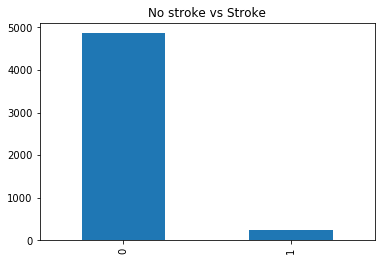

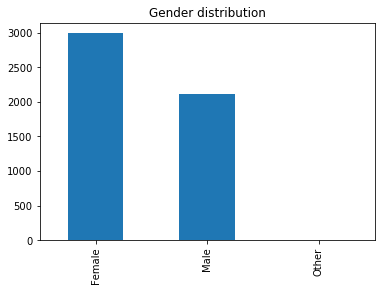

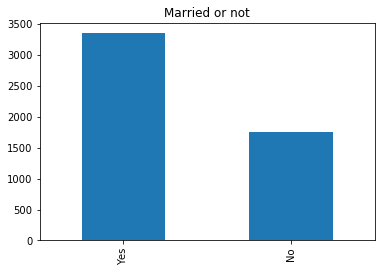

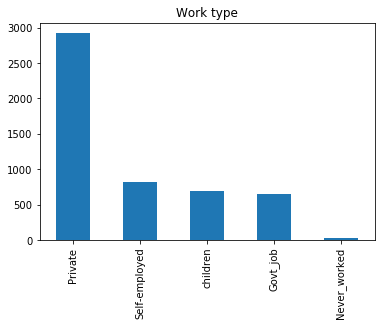

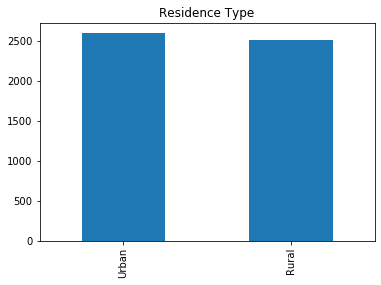

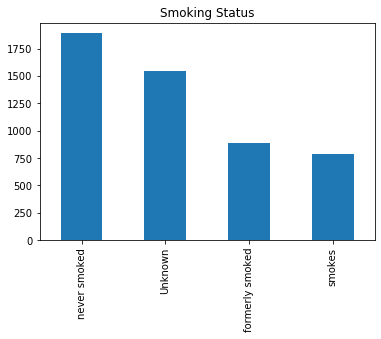

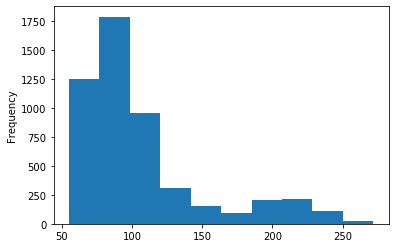

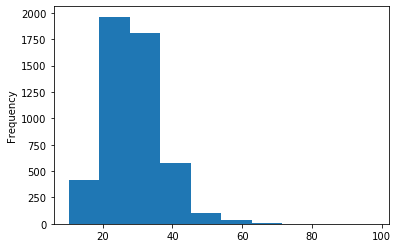

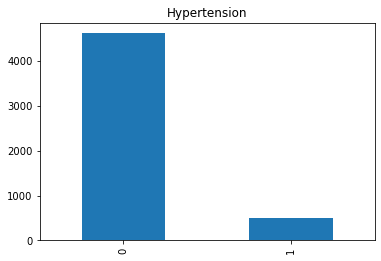

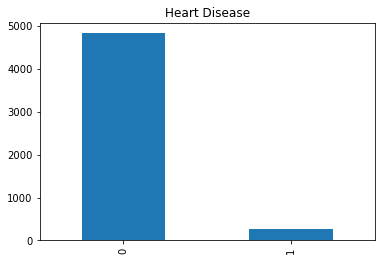

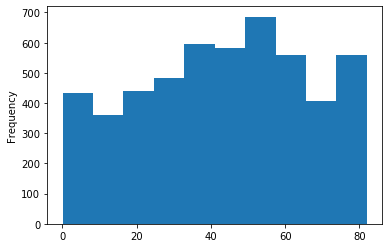

In [3]:
%run Stroke_Data_Treatment.ipynb

In [4]:
data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,228.69,36.600000,1,0,1,0,0,0,1,0,0,0,1,1,0,0
1,61.0,0,0,1,202.21,28.893237,1,1,0,0,0,0,0,1,0,1,0,0,1,0
2,80.0,0,1,1,105.92,32.500000,1,0,1,0,0,0,1,0,0,1,0,0,1,0
3,49.0,0,0,1,171.23,34.400000,1,1,0,0,0,0,1,0,0,0,1,0,0,1
4,79.0,1,0,1,174.12,24.000000,1,1,0,0,0,0,0,1,0,1,0,0,1,0


## Balancing the Stroke Class

In [5]:
# class count
class_count_0, class_count_1 = data['stroke'].value_counts()

# Separate class
class_0 = data[data['stroke'] == 0]
class_1 = data[data['stroke'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)


class 0: (4861, 20)
class 1: (249, 20)


total class of 1 and 0: 1    4861
0    4861
Name: stroke, dtype: int64


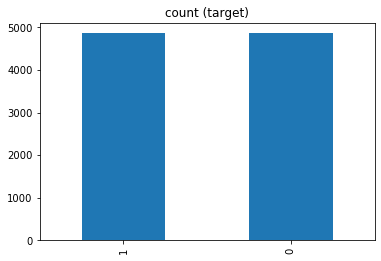

In [6]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)
print("total class of 1 and 0:",test_over['stroke'].value_counts())
test_over['stroke'].value_counts().plot(kind='bar', title='count (target)')
data = pd.concat([class_1_over, class_0], axis=0)

In [7]:
data.groupby('stroke')['age'].agg(['median','mean'])

,median,mean
stroke,,
0,43.0,41.971545
1,71.0,67.685217


stroke
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

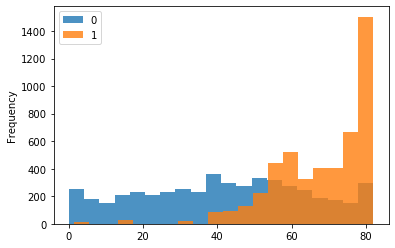

In [8]:
data.groupby('stroke')['age'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

stroke
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bmi, dtype: object

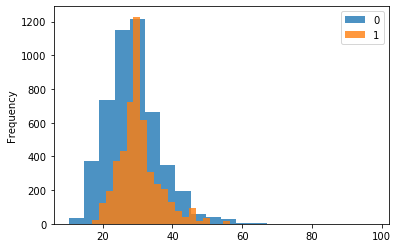

In [9]:
data.groupby('stroke')['bmi'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

## Notations, goals and methodologies

The objective of this study, is to estimate the average treatment effect of stroke on age. 
To do this, first of all we have to have the variables all clear: 
- Y represents the age of the patient. 
- D represents the treatment which in this case is having a stroke or not having a stroke. 
- X represents the confounders. 
What are confounders? in statistics, a confounder (also confounding variable, confounding factor, extraneous determinant or lurking variable) is a variable that influences both the dependent variable and independent variable, causing a spurious association. In causal analysis we do not want this, because it creates a confusion between what we want to estiamte and the actual treatment. 

What we want to know here is the **Average Treatment Effect (ATE):** $\Delta E[Y_{1}-Y_{0}]$ The ATE measures the difference in mean (average) outcomes between units assigned to the treatment (having a stroke) and units assigned to the control (not having a stroke).

**Problem to cover:** confounding variables are not desired because they create a false causal association thus, the most important thing to do, is to dissentangle the effect of D on Y from the pertubative effect (confounding) of X on Y. 

In this analysis we will use the package `causalinference` that is based on unconfoundness: $(Y(0),Y(1)) \perp W|X$, what does this mean? What this means is that if we control for X (confounder factors such as bmi, hypertension or heart_disease etc.), i.e. look across people with similar levels of X, then the difference between treated and control should be attributable to the treatment itself, just as a randomized experiment would be. 

This assuption must hold because, if it is not the case, our results could be completely wrong. 

## Causal Analysis
### a. Simple Approach
Lets first use an interpretable and easy model to fir the problem. 
$$Y_{0}= \alpha + \beta X + \epsilon$$
$$Y_{1}= Y_{0} + \gamma D$$
If this is accurate, fitting the following model to the data using linear regression will give us an estimate of the Average Treatment Effect (ATE): $$Y = \alpha + \beta X + \gamma D$$

In [10]:
confounders = ['bmi', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'gender_Female',
               'gender_Male', 'smoking_status_formerly smoked', 
               'smoking_status_never smoked', 'smoking_status_smokes']

In [11]:
causal = CausalModel(
    Y=data['age'].values, 
    D=data['stroke'].values, 
    X=data[confounders].values)

causal.est_via_ols(adj=1)
# adj=1 corresponds to the simplicity of the model we entered
# This is called a "constant treatment effect"

print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     17.658      0.357     49.408      0.000     16.957     18.358



/Users/gabrielagcolomers/opt/anaconda3/lib/python3.9/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


This model predicts that the Average Treatment Effect of having a stroke is 17.118 extra years. This means that every 17 years or so, the chances of having a stroke increase. It seems that having a stroke has a causal relationship with age, however we need more information to assure this. 

### Interpreting results 
Assuming that the model accurately explains the counterfactuals, the model gives a 95% confidence interval, which means that the ATE value will be 95% of the time in that interval; however, this does not mean that the actual ATE value is in that interval. 

As the p-value is less than 0.05 (0.00), we consider it statistically significant and reject the null hypothesis at 100%; however, the problem is that we do not know if the counterfactuals are well modelled, so we need a somewhat more sophisticated method to approach the analysis. 

### b. More complete approach

A more complete approach is necessary to estudy and evaluate the covariate balance. As we discussed earlier, our objective is to cut any relationship between the treatment and the confounder variables because, if this is not eliminated, then, the estimating effect will be wrongly related to the treatment, in other words, it will be influenced by other variables that have a relationship with the one effect we want to estimate. 

To do this, we will be using the **matching technique**: in this technique we compare subjects that have similar covariate values (i.e. same bmi, hypertension, average glucose level etc). However, our ability to compare such pairs depends heavily on the degree of overlap of the covariates between the treatment and control group.

Said otherwise, to control the effect of education (for ecample), one way is to look at people in the tested group and in the non-tested group that all have the same level of education, say they attended college or more. However, if nobody in the test group has attended college or more while many do in the non-test group, this procedure is impossible.

We will divide the approach in the following stages: 

**Pre-processing phase:**
- Assess covariate balance (1)
- Estimate propensity score (2)
- Trim sample (3)
- Stratify sample (4)


**Estimation phase:**
- Blocking estimator or/and (1)
- Matching estimator (2)

**(1) assess covariate balance** to assess how easily people can be matched. If there is too much unbalance, direct matching will rarely be possible, and we may need to use more complex techniques, if at all possible.

In [11]:
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=4861)        Treated (N_t=4861)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       41.972       22.292       67.821       12.672       25.849

                      Controls (N_c=4861)        Treated (N_t=4861)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       28.825        7.776       30.134        5.758        0.191
             X1        0.089        0.285        0.261        0.439        0.465
             X2        0.047        0.212        0.188        0.391        0.449
             X3        0.645        0.479        0.884        0.321        0.587
             X4      104.796       43.846      132.015       61.679        0.509
      

**Raw-diff** is the raw difference between the means of the control and treatment groups, as we saw previously, the treated group has 25.554 more years than the control group, is this suggesting that having a stroke is causaly realted to age? 

We also have the **Nor-diff** which refers to the Imbens and Rubin's normalized differences, stated in the paper Matching Methods in Practice: Three Examples, written in 2015, the Nor-diff compares both the control and treatment group following a formula defined as: 
$$\frac{\overline{X}_{k,t}- \overline{X}_{k,c}}{\sqrt{\frac{S^{2}_{k,t}+ S^{2}_{k,c}}{2}}}$$

As we can see, the formula is devided into $\overline{X}_{k,t}$, $S_{k,t}$ and $\overline{X}_{k,c}$, $S_{k,c}$ t referring to treatment and c to control group. $\overline{X}_{k,t}$ is the mean of the $k^{th}$ covarite being measured and $S_{k,t}$ is the standard deviation of the same covariate, all related of course, to the treatment group. For the control group is the same but, with $\overline{X}_{k,c}$ and $S_{k,c}$. 

The aim here is to assess the overlap between the control and treatment groups. If variables have a **Nor-diff** higher than 0.5 they are imbalanced. In this case a large Nor-diff value will be atributed to X1, X2, X3 and X4. 

Imbalancy makes the matching technite harder to apply, as we said earlier, an imbalanced covariant will mean that we are not able to compare between the treatment and control. 

**(2) Propensity Score** - The propensity score is the conditional probability of assignment to a particular treatment given a vector of observed covariates (Rosenbaum and rubin 1983).
As we need to have the covariates balanced, we will focus on the first property of the propensity score. 


**Property 1:** the propensity score $e(X)$ balances the distribution of all $X$ between the treatment groups $Z \perp X|e(X)$. Following this property, we can obtain several conlcusions: 
- If a subclass of units (strata, group of subjects) or a matched treatment-control pair is homogenous in $e(X)$ (has a similar propensity score), then the treatment and control units have the same distribution of $X$. 
- If a subclass of units or a matched treatment-control pair is homogenous in both $e(X)$ and certain $X$, the other components of $X$ within those refined class is also balanced. 


Propensity is useful for assessing and improving covariate balance. Indeed a theorem by Rosenbaum and Rubin in 1983, proves that, for subjects that share the same propensity score (even if their covariate vectors are different), the difference between the treated and the control units actually identifies a conditional average treatment effect.

**Thus, instead of matching on the covariate vectors X themselves (like we did on the previous method), we can also match on the single-dimensional propensity score p(X), aggregate across subjects (mix their propensity score between covariant), and still arrive at a valid estimate of the overall average treatment effect.**

reference: https://academic.oup.com/biomet/article/70/1/41/240879

The mathematical expression for what is written above is: $E[Y(1)-Y(0)|p(X)] \approx E[Y(1)-Y(0)]$
For $p(X)=P(D=1|X)$, the `CausalInference` package estimates it for us using a sequence of likelihood ratio tests.

In [12]:
causal.est_propensity_s()
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -5.422      0.465    -11.660      0.000     -6.333     -4.510
            X3      2.999      0.338      8.869      0.000      2.337      3.662
            X1      4.676      0.382     12.242      0.000      3.927      5.424
            X2      1.971      0.341      5.783      0.000      1.303      2.639
            X4     -0.029      0.003     -9.156      0.000     -0.035     -0.023
            X7     -0.025      0.227     -0.110      0.912     -0.470      0.420
            X0      0.288      0.026     11.254      0.000      0.238      0.338
            X5      0.892      0.159      5.620      0.000      0.581      1.203
         X0*X0     -0.005      0.000    -11.222      0.000     -0.006     -0.004
         X3*X1     -2.052      0.214     -9.577      0.000     -2.

Having a really high propensity score, means that the probability to be either in the control group or in the treatment group is really high, that is why, the best thing to do is to eliminate those subjects that have a high propensity score. The trim function will drop units whose estimated propensity score are <= 0.1 or >= 0.9 but we will rather use the `trim_s()` function to select the optimal cutoff value. 

**(3) Trim sample.** Eliminates those that have a high propensity score according to the threshold stablished above. 

In [13]:
causal.trim_s()

In [14]:
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=4036)        Treated (N_t=4434)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       47.115       19.371       67.435       12.976       20.319

                      Controls (N_c=4036)        Treated (N_t=4434)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       30.008        6.353       29.926        5.835       -0.013
             X1        0.101        0.302        0.253        0.435        0.405
             X2        0.048        0.214        0.123        0.329        0.270
             X3        0.755        0.430        0.895        0.306        0.375
             X4      104.675       44.602      126.679       58.162        0.425
      

In this new subset, the calculations are rather balanced, we can see the X4 has still a value pretty clase to 0.5 but still is not 0.5. If we look closely to the table, we can see that the number of control and treated patients has chaged, this is because the trim function tries to balance as much as possible the subjects. Before we had: 4861 as controls and 4861 as treated; now we have: 4027 controlls and 4527 treated (this change, however is not very relevant for us). 

In this more balanced sub-sample, without using any model, the average age is 19.94 more years in treated subjects, so it is really what we were expecting: those that have a stroke appear to be older than those who have not, does this mean age and stroke are causaly related? 

**(4) Stratify sample -** We want to group different subjects with similar propensity scores and evaluate the causal effect only within that group. The ideal thing to do is to make groups that are not to large neither to small, in this way our work will be more "balanced". Individuals are classified in strata of approximately equal size, then the causal effect is estimated in each of the strata. 

In [15]:
causal.stratify_s()
print(causal.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.114     0.150       245        21     0.132     0.136    53.748
         2     0.150     0.173       170        95     0.161     0.163    29.314
         3     0.174     0.267       416       113     0.214     0.211    31.937
         4     0.267     0.353       367       163     0.311     0.316    13.846
         5     0.353     0.416       318       211     0.392     0.387    14.982
         6     0.416     0.492      1146       971     0.453     0.454    14.977
         7     0.492     0.562       344       209     0.524     0.527    16.243
         8     0.562     0.591       218       301     0.577     0.576    14.993
         9     0.591     0.633       162       372     0.607     0.610     7.584
   

/Users/gabriela/opt/anaconda3/lib/python3.8/site-packages/causalinference/core/summary.py:110: RuntimeWarning: invalid value encountered in true_divide
  return (mean_t-mean_c) / np.sqrt((sd_c**2+sd_t**2)/2)


To understand the stratify sample phase, we must look closely at the table. First we will focus on `controls` and `sample sized Treated` it seems that in almost all groups the controls are higher than the treated except for group 11, 13, 15, 17, 18, 19 and 20 , where we have more treated than controls, this indicates that those groups are likely to be treated, they are likely to have a stroke because of their high age. (`raw-diff`). 

For the other groups, it is logical to say that they are unlikely to be treated because they have far more controls than treated patients. 

Let's see in the analysis phase if regressions within each stratum will be able to control for confounding variables better.

#### Estimation Phase 
For some reason I'm having a singular matrix when calculating the bloking estimator.
I've tried changing the set of variables, however, the singularity persists when calculating the covariance matrix, this is one of the issue of this causalinference package: it needs to invert large matrixes, which can fail. 


**(2) The matching estimator** - We must control for the confounding factors within each layer of the stratum. The estimator used implies a nearest-neighborhood matching by finding, for every treated unit, one (or more) non-treated unit(s) with similar observable characteristics against who the covariates are balanced out. By matching treated units to similar non-treated units, matching enables a comparison of outcomes among treated and non-treated units to estimate the effect of the treatment reducing bias due to confounding.

In [16]:
causal.est_via_matching(bias_adj=True, matches=4)
print(causal.estimates)

/Users/gabriela/opt/anaconda3/lib/python3.8/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     14.951      0.647     23.112      0.000     13.683     16.218
           ATC     18.688      0.523     35.718      0.000     17.662     19.713
           ATT     11.549      0.974     11.862      0.000      9.641     13.457



This is very interesting. The matching technique is telling us that the ATE estimation for having a stroke in age is 14.679 years, in other words, people that suffer a stroke are normally 14.679 years older than those who dont, but, is this statistically significant? Can we say that age is causaly related to stroke? Oh Yes! Look at the p value, it is in fact lower than 0.05, then we can conclude our results are statistically significant and we can reject the null hypothesis with a probability of 100%. 

Having a stroke is causaly realated to age, of course, this does not mean that if you reach 78 years old you are going to have a stroke, it rather means that if you have a stroke at 78 years old it will be caused by the age (most probably speaking). 

This NCBI study here, supports in fact our theory, the risk of having a stroke increases each decade (exacly each 15 years as we saw). https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3006180/#:~:text=The%20risk%20increases%20with%20age,will%20result%20in%20death1.